In [2]:
import os 
import random 
import math 
from operator import itemgetter 
from collections import OrderedDict


import numpy as np 
import matplotlib.pyplot as plt

import torch
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim
from torch.utils.data import DataLoader 

from torchvision import datasets, transforms

from models.involution import Involution2d

In [3]:

# ====================================== #
# function to count number of parameters #
# ====================================== # 
""" 모델 파라미터 세는 방법; (ref) https://aigong.tistory.com/196
"""


def get_n_params(model):
    np=0
    for p in list(model.parameters()):  # (ref) https://easy-going-programming.tistory.com/11
        np += p.nelement()   # (ref) https://pytorch.org/docs/stable/generated/torch.Tensor.nelement.html#
    return np

In [4]:
# ===== Set device 
gpu_no = 0
device = torch.device( f'cuda:{gpu_no}' if torch.cuda.is_available() else 'cpu')
print(f"device: {device}")

device: cuda:0


In [5]:
# ============ #
# Reproducible #
# ============ # 
""" 
    (ref) https://hoya012.github.io/blog/reproducible_pytorch/
    (ref) https://stackoverflow.com/questions/58961768/set-torch-backends-cudnn-benchmark-true-or-not
"""
seed = 42

os.environ["PYTHONHASHSEED"] = str(seed)    # set PYTHONHASHSEED env var at fixed value
                                            # (ref) https://dacon.io/codeshare/2363
                                            # (ref) https://www.programmersought.com/article/16615747131/
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if use multi-GPU

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Load the dataset (CIFAR-10)

In [6]:
# (ref) https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
transform = transforms.Compose( [   transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                ])

batch_size = 128
n_workers = 4                             

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform )
testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform )    


train_loader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=n_workers)                                                                          
test_loader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=True, num_workers=n_workers)                                                                          


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


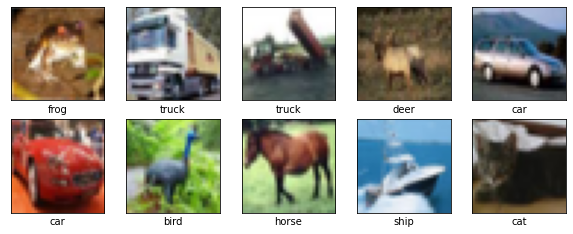

('frog', 'truck', 'truck', 'deer', 'car', 'car', 'bird', 'horse', 'ship', 'cat')


In [7]:
# ===== show some images
plt.figure(figsize=(10,10))

labels = []

for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)    

    img, label = train_loader.dataset.__getitem__(i)  # (ref) https://deepbaksuvision.github.io/Modu_ObjectDetection/posts/03_01_dataloader.html
                                                    # (ref) https://jinmay.github.io/2019/11/26/python/python-instance-slice/
    img = img / 2 + 0.5     # unnormalize                                                    
    img = img.numpy()

    labels.append(label)

    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.xlabel(classes[label])

plt.show()

print(itemgetter(*labels)(classes))  # (ref) https://stackoverflow.com/questions/18272160/access-multiple-elements-of-list-knowing-their-index

## Create the model classes 
* [refer to](https://github.com/ariG23498/involution-tf/blob/master/Involution.ipynb)

In [8]:
# ========================= #
#  Convolution neural nets  # 
# ========================= #
class CNN(nn.Module):
    # (ref) https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
    
    def __init__(self, in_channels:int, out_channels:int, num_classes:int):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride = (2,2))
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=out_channels, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.fc1 = nn.Linear(out_channels*8*8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    
    def forward(self, x):
        assert x.ndimension() == 4, f"Input tensor must be 4d! but, {x.ndimension()}d tensor is given"
                
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x    
                                    






# ========================= #
#  Involution neural nets  # 
# ========================= #
# (ref) https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html
class INN(nn.Module):
    def __init__(self, in_channels:int, out_channels:int, num_classes:int):
        super(INN, self).__init__()

        
        self.inv1 = Involution2d(in_channels=in_channels, out_channels=6)
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride = (2,2))
        self.inv2 = Involution2d(in_channels=6, out_channels=out_channels)
        self.fc1 = nn.Linear(out_channels*8*8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)



    def forward(self, x:torch.Tensor) -> torch.Tensor:
        assert x.ndimension() == 4, f"Input tensor must be 4d! but, {x.ndimension()}d tensor is given"

        x = self.pool(F.relu(self.inv1(x)))
        x = self.pool(F.relu(self.inv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x 


## Running on a GPU: device string 

In [9]:
accuracy_list = []



# ========================= #
#        Train-loop         # 
# ========================= #
def train(epoch, model, optimizer, criterion, train_loader):

    model.train()  # (ref) https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch

    losses = [] 

    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # forward
        scores = model(data)   # 모델이 예측한 수치 
        loss = criterion(scores, target)

        
        # backward
        optimizer.zero_grad()   # AutoGrad 하기 전에 매번 mini batch 별로 기울기 수치를 0으로 초기화 
        loss.backward()
        losses.append(loss.item())
        
        # gradient descent and update params 
        optimizer.step()


        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')




# ========================= #
#    Validation-loop        # 
# ========================= #
def val(model, criterion, test_loader):

    model.eval()

    test_loss = 0
    num_correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            # send to device
            data, target = data.to(device), target.to(device)


            # forward
            scores = model(data)   # 모델이 예측한 수치 
            loss = criterion(scores, target)  
            test_loss += loss 

            pred = scores.argmax(dim=1)

            num_correct += (pred == target).sum().item() # torch.eq() ; (ref) https://pytorch.org/docs/stable/generated/torch.eq.html

        test_loss /= len(test_loader.dataset)
        accuracy = 100. * num_correct / len(test_loader.dataset)
        accuracy_list.append(accuracy)

        print(f'\n Val set: Average loss: {test_loss:.4f}, Accuracy: {num_correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n')

## Train a Convolution Net 

In [10]:
img = torch.randn([128, 3, 32, 32]).to(device)
model_cnn =  CNN(in_channels=3, out_channels=16, num_classes=10).to(device)

out = model_cnn(img)
print(out.shape)

torch.Size([128, 10])


In [11]:
model_cnn =  CNN(in_channels=3, out_channels=16, num_classes=10).to(device)
print(f'Number of parameters: {get_n_params(model_cnn)}')


criterion = nn.CrossEntropyLoss()   
optimizer = optim.Adam( model_cnn.parameters(), lr=1e-3)
#optimizer = optim.SGD(model_cnn.parameters(), lr=1e-3, momentum=0.9)


for epoch in range(0, 10):
    train(epoch, model_cnn, optimizer, criterion, train_loader)
    val(model_cnn, criterion, test_loader)

Number of parameters: 135062
Train Epoch: 0 [0/50000 (0%)]	Loss: 2.309678
Train Epoch: 0 [12800/50000 (26%)]	Loss: 1.777613
Train Epoch: 0 [25600/50000 (51%)]	Loss: 1.677531
Train Epoch: 0 [38400/50000 (77%)]	Loss: 1.544649

 Val set: Average loss: 0.0118, Accuracy: 4523/10000 (45%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.574139
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.274958
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.476720
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.340256

 Val set: Average loss: 0.0103, Accuracy: 5233/10000 (52%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.122883
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.468907
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.044643
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.224778

 Val set: Average loss: 0.0096, Accuracy: 5647/10000 (56%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.100554
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.131743
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.136785
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.063859

 Val se

## Train a Involution Net

In [12]:
img = torch.randn([128, 3, 32, 32]).to(device)
model_inn =  INN(in_channels=3, out_channels=16, num_classes=10).to(device)

out = model_inn(img)
print(out.shape)

torch.Size([128, 10])


In [13]:
model_inn =  INN(in_channels=3, out_channels=16, num_classes=10).to(device)
print(f'Number of parameters: {get_n_params(model_inn)}')


criterion = nn.CrossEntropyLoss()   
optimizer = optim.Adam( model_inn.parameters(), lr=1e-3)
#optimizer = optim.SGD(model_inn.parameters(), lr=1e-3, momentum=0.9)


for epoch in range(0, 10):
    train(epoch, model_inn, optimizer, criterion, train_loader)
    val(model_inn, criterion, test_loader)

Number of parameters: 135364
Train Epoch: 0 [0/50000 (0%)]	Loss: 2.398530
Train Epoch: 0 [12800/50000 (26%)]	Loss: 1.899187
Train Epoch: 0 [25600/50000 (51%)]	Loss: 1.669205
Train Epoch: 0 [38400/50000 (77%)]	Loss: 1.666777

 Val set: Average loss: 0.0129, Accuracy: 4262/10000 (43%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.653721
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.595002
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.536976
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.439943

 Val set: Average loss: 0.0117, Accuracy: 4660/10000 (47%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.429672
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.411296
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.415939
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.571581

 Val set: Average loss: 0.0112, Accuracy: 4878/10000 (49%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.321198
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.291646
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.311653
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.413288

 Val se